# Notebook to create the confusion matrices 
Also calculates accuracy metrics

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb
import pandas as pd
import os
import ast
import warnings
from statsmodels.stats.proportion import proportion_confint
from matplotlib.colors import LinearSegmentedColormap
from torch.utils.data import DataLoader
from omegaconf import OmegaConf
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from src.modeling.siglabv2.siglabv2 import SigLabV2
from src.modeling.datasets.siglab_dataset import SigLabDataset
from src.run import lead_sets
from src.utils import count_parameters, confusion_matrix, apply_preprocessors, PRECORDIAL_LEAD_NAMES
from src.data.load_ptbdata_new import PRECORDIAL_LEADS, LIMB_LEADS, AUGMENTED_LEADS, ALL_LEADS
from src.evaluation import set_level_accuracy, lead_level_accuracy, bootstrap_lead_accuracy

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


2025-06-01 21:51:33.157 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\natem\bachelors_thesis


## Loading the model

In [11]:
project_path = "nateml-maastricht-university/bachelors-thesis"
#run_id = "83mabq4k"
#version = "v22"
run_id = "yh0by5uj"  # replace with wandb run id of interest
version = "v30"  # model checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the torch model from wandb
api = wandb.Api()

run = api.run(f"{project_path}/{run_id}")
config = dict(run.config)

# Get the run name
run_name = run.name

artifact = api.artifact(f"{project_path}/{run_name}:{version}")
artifact_path = artifact.download()

# Convert config to omegaconf
cfg = OmegaConf.create(config)

# Load the model
checkpoint = torch.load(artifact_path + f"/{run_name}.pth", map_location=device)

# Cast the model to the correct type
model = SigLabV2(cfg.model).to(device)
model.load_state_dict(checkpoint)
model.eval()  # Put into evaluation mode

# Count number of parameters
print(f"Loaded model from wandb: {run_name}")
count_parameters(model)

wandb:   1 of 1 files downloaded.  


Loaded model from wandb: 63_siglabv2_inception_gru_2_2
+----------------------------------------+------------+
|                Modules                 | Parameters |
+----------------------------------------+------------+
|             encoder.alpha              |     1      |
| encoder.cnn_encoder.0.branch1.0.weight |     32     |
|  encoder.cnn_encoder.0.branch1.0.bias  |     32     |
| encoder.cnn_encoder.0.branch1.1.weight |     32     |
|  encoder.cnn_encoder.0.branch1.1.bias  |     32     |
| encoder.cnn_encoder.0.branch2.0.weight |     1      |
|  encoder.cnn_encoder.0.branch2.0.bias  |     1      |
| encoder.cnn_encoder.0.branch2.1.weight |     1      |
|  encoder.cnn_encoder.0.branch2.1.bias  |     1      |
| encoder.cnn_encoder.0.branch2.3.weight |    160     |
|  encoder.cnn_encoder.0.branch2.3.bias  |     32     |
| encoder.cnn_encoder.0.branch2.4.weight |     32     |
|  encoder.cnn_encoder.0.branch2.4.bias  |     32     |
| encoder.cnn_encoder.0.branch3.0.weight |     1 

(1365845, 307017)

In [3]:
model

SigLabV2(
  (encoder): CNNGRUEncoder(
    (activation): ReLU()
    (cnn_encoder): Sequential(
      (0): InceptionBlock(
        (activation): ReLU()
        (branch1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv

Optionally save the model to disk by uncommenting the code below.

In [ ]:
# Save the model
# model_path = Path("../../models/siglabv2")
# model_name = run_name
# model_path.mkdir(parents=True, exist_ok=True)

# Save the full model
# torch.save(model, model_path / f"siglabv2.pth")
# torch.save(model.state_dict(), model_path / f"state_dict.pth")
# OmegaConf.save(cfg, model_path / f"config.yaml")

## Inference

In [12]:
dataset_path = Path("../../" + cfg.dataset.path)
if OmegaConf.select(cfg, "dataset.only_precordial"):
    dataset_path = dataset_path / "precordial"
else:
    dataset_path = dataset_path / "all"
dataset_path = dataset_path.resolve()

val_data = np.load(dataset_path / "val.npy")
test_data = np.load(dataset_path / "test.npy")

# Apply preprocessors
val_data = apply_preprocessors(val_data,
                               cfg.dataset.sampling_rate,
                               cfg.preprocessor_group.preprocessors)
test_data = apply_preprocessors(test_data,
                                 cfg.dataset.sampling_rate,
                                 cfg.preprocessor_group.preprocessors)
 
# Convert to torch tensor
val_data = torch.from_numpy(val_data).float().to(device)
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

test_data = torch.from_numpy(test_data).float().to(device)
test_data = test_data.permute(0, 2, 1)

# Create the dataset and dataloader
lead_filter = lead_sets[OmegaConf.select(cfg, "run.leads", default="precordial")]
dataset = SigLabDataset(test_data, filter_leads=lead_filter)
batch_size = 32
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False)

# I need to reorder val_data to match the order of the labels in the dataset
if OmegaConf.select(cfg, "dataset.only_precordial") or OmegaConf.select(cfg, "dataset.only_precordial") is None:
    val_data = val_data[:, [PRECORDIAL_LEADS.index(lead) for lead in lead_filter], :]
    test_data = test_data[:, [PRECORDIAL_LEADS.index(lead) for lead in lead_filter], :]
else:
    val_data = val_data[:, [ALL_LEADS.index(lead) for lead in lead_filter], :]
    test_data = test_data[:, [ALL_LEADS.index(lead) for lead in lead_filter], :]

# Load metadata
meta_val = pd.read_csv(dataset_path / "meta_val.csv")
meta_test = pd.read_csv(dataset_path / "meta_test.csv")
meta = meta_test.copy()
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(lambda x: codes_above_threshold(x, THRESHOLD))

# Treat diagnostic superclass as lists
meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: ast.literal_eval(x))
# Now convert to a set
meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: set(x))

c = cfg.model.num_classes
logits = np.zeros((len(dataset), c, c))
init_logits = np.zeros((len(dataset), c, c))
targets = np.zeros((len(dataset), c))

for idx, (signals, lead_labels) in enumerate(dataloader):
    signals = signals.to(device)
    lead_labels = lead_labels.to(device)

    # Make predictions
    with torch.no_grad():
        these_logits = model(signals)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()
        targets[(idx * batch_size):(idx * batch_size + batch_size)] = lead_labels.cpu().numpy()

predictions = logits.argmax(axis=-1)
print(predictions.shape)

torch.Size([2183, 6, 1000])
(2198, 6)


In [ ]:
# Optionally save the model's predictions by uncommenting the following lines

# np.save(model_path / "output_test.npy", predictions)
# meta.to_csv(model_path / "meta_test.csv", index=False)
# np.save(model_path / f"targets_test.npy", targets)

In [7]:
# The indices of V2-V6 swaps, for example, can be found like this
np.where(predictions[:, 5] == 1)[0]

array([1376, 1701])

## Results

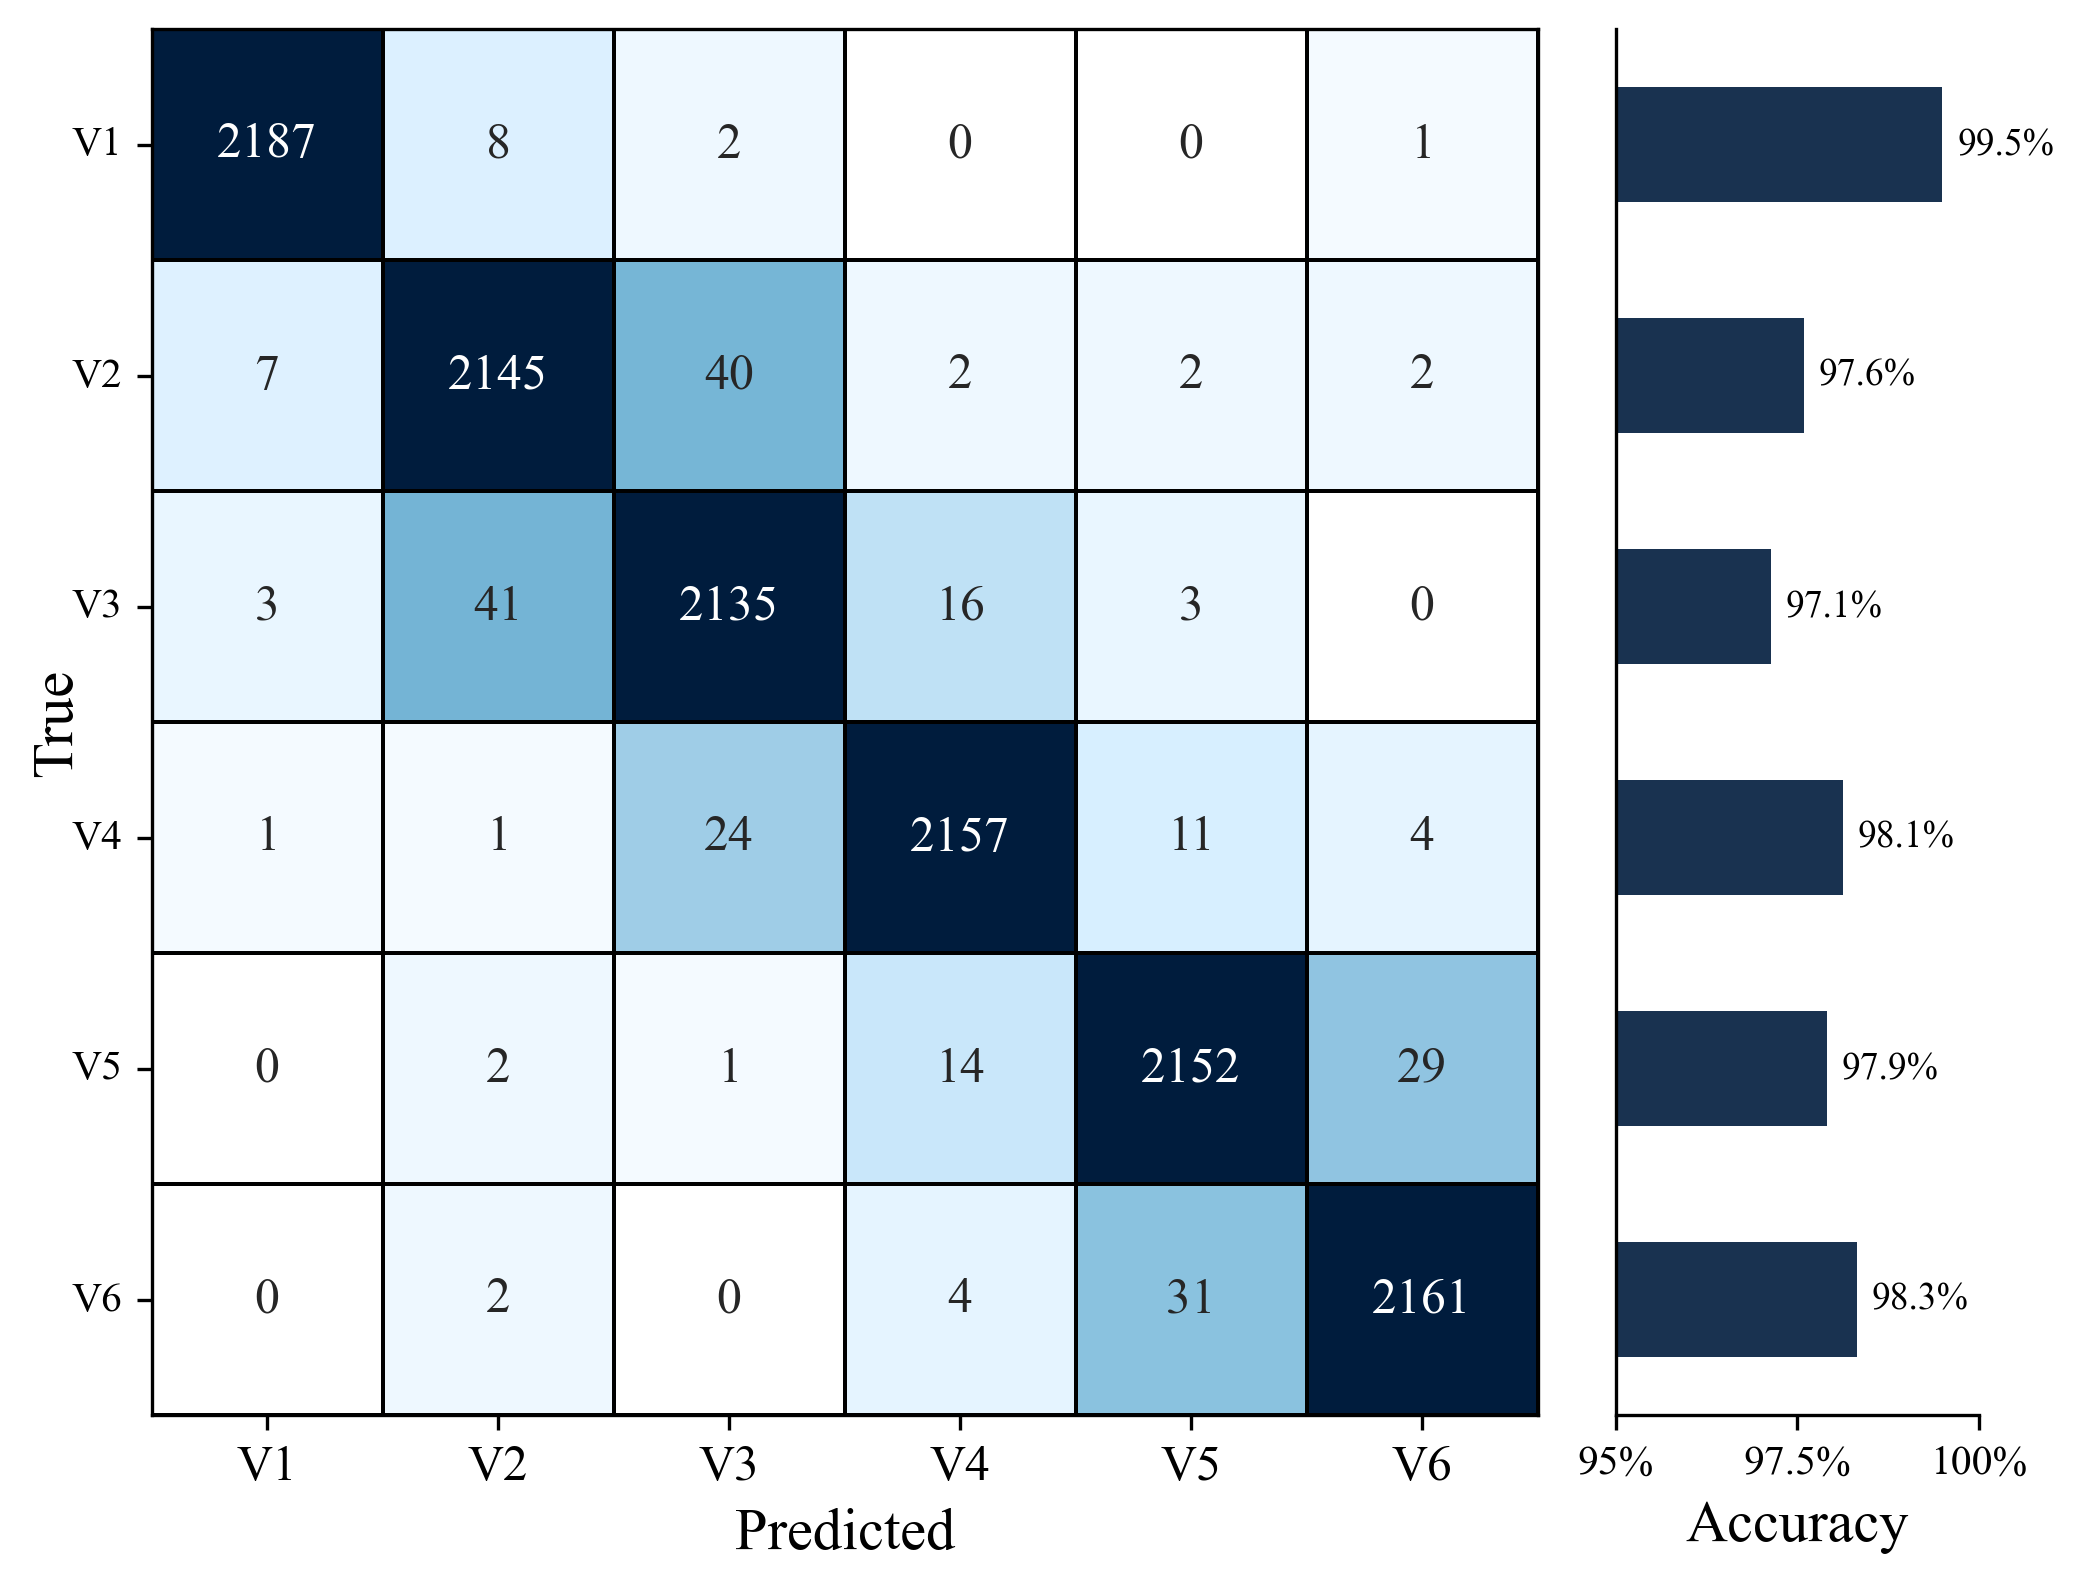

In [ ]:
# Confusion matrix
dark_blue = "#001C3D"
light_blue = "#00A2DB"
orange = "#F39425"
orange_red = "#E84E10"

um_cmap = LinearSegmentedColormap.from_list(
    "um_blues", ['#ffffff', '#d6eeff', '#0070A3', dark_blue], N=256
)

plt.rcParams.update({
    "font.family":  "serif",              # or "sans-serif" if you prefer CMU Bright
    "font.serif":   ["Times New Roman"],       # fallback to CMR if Bright missing
    "axes.labelsize": 12,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "font.weight": "regular",
    "mathtext.fontset": "cm",
    "axes.titlepad": 0,
    "axes.labelpad": 4,
})

cm = confusion_matrix(predictions, targets)
cm_log = np.log(cm + 1)

# calculate per lead accuracies
# in this case it is just the diagonal divided by the sum of the row,
# which is the same for all leads
accs = np.zeros((cm.shape[0],))
sums = np.sum(cm, axis=1)
for i in range(cm.shape[0]):
    accs[i] = cm[i, i] / sums[i]

# Plot the confusion matrix
fig = plt.figure(figsize=(8, 6), dpi=300)
gs = fig.add_gridspec(1, 2, width_ratios=(4, 1), wspace=0.05)
ax_cm = fig.add_subplot(gs[0, 0])
ax_bar = fig.add_subplot(gs[0, 1], sharey=ax_cm)

# Plot the confusion matrix
sns.heatmap(cm_log, ax=ax_cm, annot=cm, fmt="d", cmap=um_cmap, cbar=False, square=True,
            xticklabels=lead_filter, yticklabels=lead_filter,
            annot_kws={"size": 12, "weight": "regular"}, linecolor="black", linewidths=0.5)
ax_cm.set_xlabel("Predicted", fontsize=14, weight="regular")
ax_cm.set_ylabel("True", fontsize=14, weight="regular", labelpad=-3)
ax_cm.set_yticklabels(lead_filter, rotation=0, fontsize=10, weight="regular")
for spine in ax_cm.spines.values():
    spine.set_visible(True)

# Plot the bar plot
y_pos = np.arange(cm.shape[0])
# Reverse the order of the y-axis
#y_pos = y_pos[::-1]
ax_bar.barh(y_pos + 0.5, accs, align='center', color=dark_blue, alpha=0.9, height=0.5)
ax_bar.set_xlim(0.95, 1)
ax_bar.set_xticks([0.95, 0.975, 1])
ax_bar.set_xticklabels(['95%', '97.5%', '100%'], fontsize=10, weight="regular")
#ax_bar.set_yticks(y_pos)
#ax_bar.set_yticklabels([])
ax_bar.set_xlabel("Accuracy", fontsize=14, weight="regular")

# Hide the y-axis ticks
ax_bar.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

# Add accuracy values to the bar plot
for i, v in enumerate(accs):
    ax_bar.text(v + 0.002, i + 0.5, f"{v*100:.1f}%", color='black', va='center', fontsize=9, weight="regular")

# Clear spines 
for spine in ['top', 'right']:
    ax_bar.spines[spine].set_visible(False)

# Remove whitespace around the figure
plt.tight_layout()
# Save the figure
plt.savefig(f"figures/confusion_matrix_{run_name}.png", bbox_inches="tight", dpi=400)

In [14]:
# Calculate confusion matrices for each PTB-XL diagnostic class
# Get indices where 'NORM' is in the 'diagnostic_superclass' column which contains lists
norm_idx = np.where(meta['diagnostic_superclass'].apply(lambda x: 'NORM' in x))[0]
cm_norm = confusion_matrix(predictions[norm_idx], targets[norm_idx])
cm_norm_log = np.log(cm_norm + 1)

mi_idx = np.where(meta['diagnostic_superclass'].apply(lambda x: 'MI' in x))[0]
cm_mi = confusion_matrix(predictions[mi_idx], targets[mi_idx])
cm_mi_log = np.log(cm_mi + 1)

cd_idx = np.where(meta['diagnostic_superclass'].apply(lambda x: 'CD' in x))[0]
cm_cd = confusion_matrix(predictions[cd_idx], targets[cd_idx])
cm_cd_log = np.log(cm_cd + 1)

sttc_idx = np.where(meta['diagnostic_superclass'].apply(lambda x: 'STTC' in x))[0]
cm_sttc = confusion_matrix(predictions[sttc_idx], targets[sttc_idx])
cm_sttc_log = np.log(cm_sttc + 1)

hyp_idx = np.where(meta['diagnostic_superclass'].apply(lambda x: 'HYP' in x))[0]
cm_hyp = confusion_matrix(predictions[hyp_idx], targets[hyp_idx])
cm_hyp_log = np.log(cm_hyp + 1)

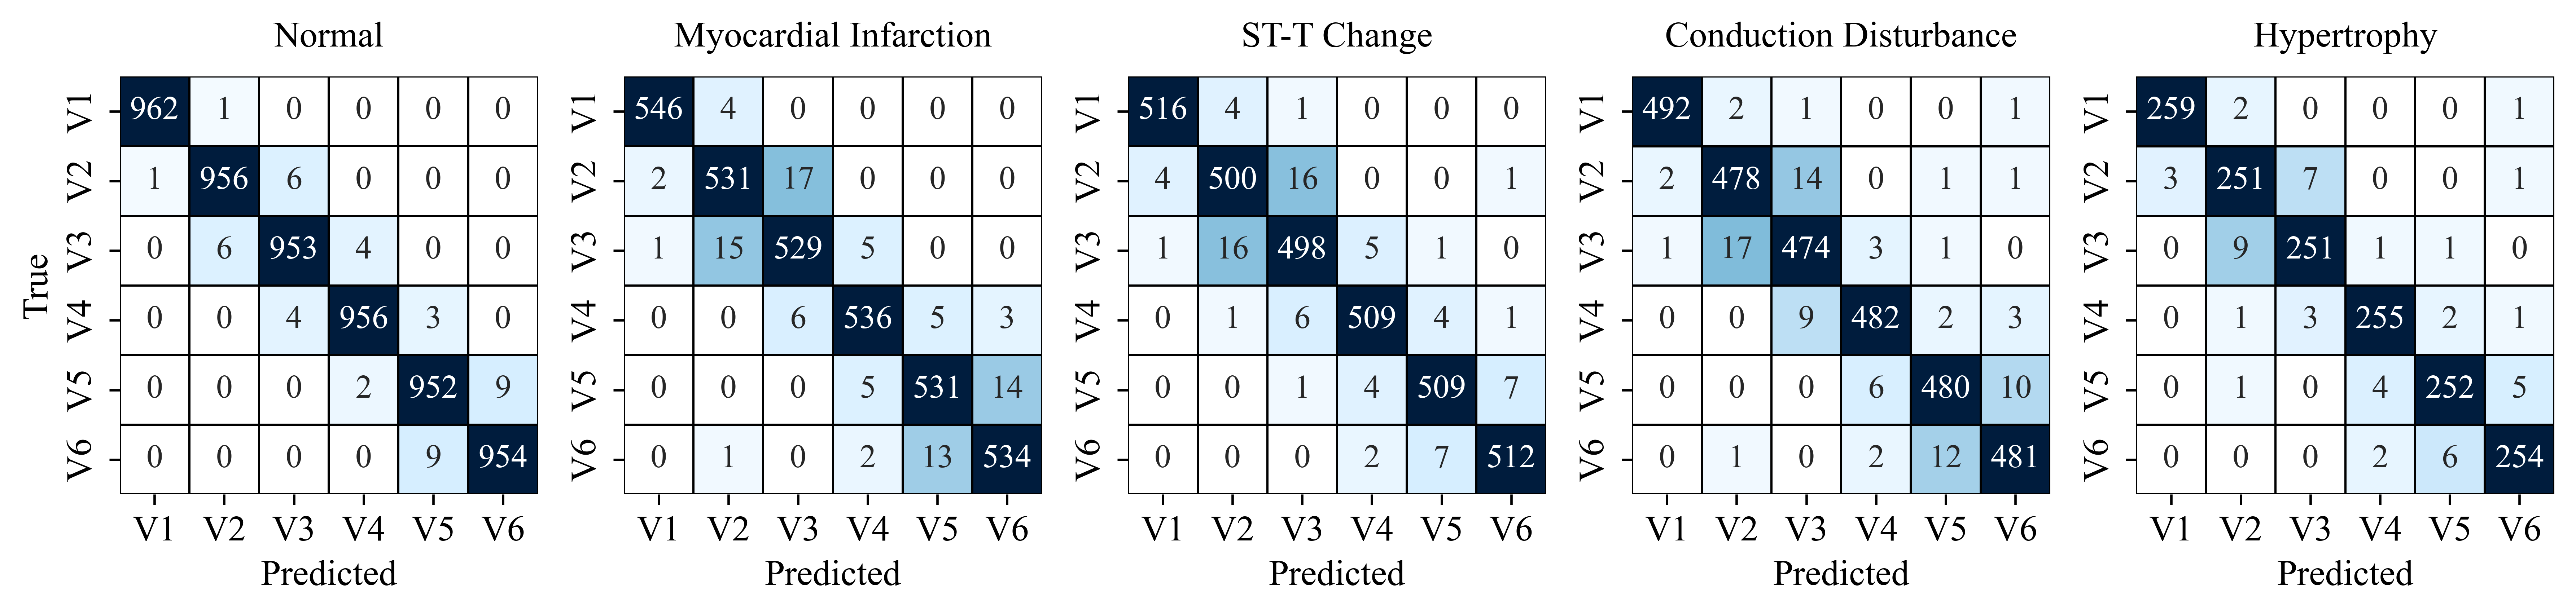

In [16]:

# Define the Maastricht University blue and yellow colors for the theme
MAASTRICHT_BLUE = "#1D4E89"  # Maastricht University blue
MAASTRICHT_YELLOW = "#FFD700"  # Maastricht University yellow

light_blue = "#00A2DB"

plt.rcParams.update({
    "font.family":  "serif",              # or "sans-serif" if you prefer CMU Bright
    "font.serif":   ["Times New Roman"],       # fallback to CMR if Bright missing
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "font.weight": "regular",
    "mathtext.fontset": "cm",
    "axes.titlepad": 10,
})

# Visualize the confusion matrices with Maastricht University theme
plt.figure(figsize=(12, 9), dpi=600)

conf_mats = [
    ("Normal",                 cm_norm,        cm_norm_log),
    ("Myocardial Infarction",  cm_mi,          cm_mi_log),
    ("ST-T Change",            cm_sttc,        cm_sttc_log),
    ("Conduction Disturbance", cm_cd,          cm_cd_log),
    ("Hypertrophy",            cm_hyp,         cm_hyp_log),
]

for i, (title, cm_raw, cm_log) in enumerate(conf_mats, start=1):
    plt.subplot(1, 5, i)
    sns.heatmap(cm_log, annot=cm_raw, fmt="d", cmap=um_cmap, cbar=False, square=True,
                xticklabels=lead_filter, yticklabels=lead_filter,
                annot_kws={"size": 11, 'weight': 'regular'}, linewidths=0.5, linecolor='black')
    plt.title(title, fontsize=12, fontweight='regular')
    if i == 1:
        plt.ylabel("True", fontsize=12, fontweight='regular')
    plt.xlabel("Predicted", fontsize=12, fontweight='regular')

# Save the figure
# plt.savefig("figures/confusion_matrices.png", dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [29]:
cm[0,:]

array([2180,    6,    0,    2,    1,    1,    0,    0,    5,    2,    1,
          0])

In [68]:
np.trace(cm)/np.sum(cm)

np.float64(0.9845313921747043)

In [ ]:

# Calculate recall for each lead, as well as the confidence intervals
def calculate_recall_and_ci(cm):
    recalls = np.zeros(cm.shape[0])
    ci_lower = np.zeros(cm.shape[0])
    ci_upper = np.zeros(cm.shape[0])
    
    for i in range(cm.shape[0]):
        true_positive = cm[i, i]  # predicted lead i correctly
        false_negative = np.sum(cm[i, :]) - true_positive  # predicted incorrectly when it was actually lead i
        total = true_positive + false_negative  # total number of times it was actually lead i
        
        if total > 0:
            recalls[i] = true_positive / total
            ci_lower[i], ci_upper[i] = proportion_confint(true_positive, total, alpha=0.05, method='wilson')
        else:
            recalls[i] = 0
            ci_lower[i] = 0
            ci_upper[i] = 0
            
    return recalls, ci_lower, ci_upper

def calculate_recall_and_ci_total(cm):
    true_positive = np.trace(cm)
    false_negative = np.sum(cm) - true_positive
    total = true_positive + false_negative
    
    if total > 0:
        recall = true_positive / total
        ci_lower, ci_upper = proportion_confint(true_positive, total, alpha=0.05, method='wilson')
    else:
        recall = 0
        ci_lower = 0
        ci_upper = 0
        
    return recall, ci_lower, ci_upper

PRECISION = 3

# Calculate recall and confidence intervals for each diagnostic class
recalls_norm, ci_lower_norm, ci_upper_norm = calculate_recall_and_ci(cm_norm)
recalls_mi, ci_lower_mi, ci_upper_mi = calculate_recall_and_ci(cm_mi)
recalls_sttc, ci_lower_sttc, ci_upper_sttc = calculate_recall_and_ci(cm_sttc)
recalls_cd, ci_lower_cd, ci_upper_cd = calculate_recall_and_ci(cm_cd)
recalls_hyp, ci_lower_hyp, ci_upper_hyp = calculate_recall_and_ci(cm_hyp)
recalls_total, ci_lower_total, ci_upper_total = calculate_recall_and_ci(cm)

total_recall_all, total_ci_lower_all, total_ci_upper_all = calculate_recall_and_ci_total(cm)
total_recall_norm, total_ci_lower_norm, total_ci_upper_norm = calculate_recall_and_ci_total(cm_norm)
total_recall_mi, total_ci_lower_mi, total_ci_upper_mi = calculate_recall_and_ci_total(cm_mi)
total_recall_sttc, total_ci_lower_sttc, total_ci_upper_sttc = calculate_recall_and_ci_total(cm_sttc)
total_recall_cd, total_ci_lower_cd, total_ci_upper_cd = calculate_recall_and_ci_total(cm_cd)
total_recall_hyp, total_ci_lower_hyp, total_ci_upper_hyp = calculate_recall_and_ci_total(cm_hyp)
print(f"Total recall for all leads: {total_recall_all:.3f} ({total_ci_lower_all:.3f}, {total_ci_upper_all:.3f})")
print(f"Total recall for NORM leads: {total_recall_norm:.3f} ({total_ci_lower_norm:.3f}, {total_ci_upper_norm:.3f})")
print(f"Total recall for MI leads: {total_recall_mi:.3f} ({total_ci_lower_mi:.3f}, {total_ci_upper_mi:.3f})")
print(f"Total recall for STTC leads: {total_recall_sttc:.3f} ({total_ci_lower_sttc:.3f}, {total_ci_upper_sttc:.3f})")
print(f"Total recall for CD leads: {total_recall_cd:.3f} ({total_ci_lower_cd:.3f}, {total_ci_upper_cd:.3f})")
print(f"Total recall for HYP leads: {total_recall_hyp:.3f} ({total_ci_lower_hyp:.3f}, {total_ci_upper_hyp:.3f})")

# Create a DataFrame including just the recall for the diagnostic classes and the recall + confidence intervals for the total
recall_data = {
    "Lead": lead_filter,
    "Recall (NORM)": recalls_norm,
    "Recall (MI)": recalls_mi,
    "Recall (STTC)": recalls_sttc,
    "Recall (CD)": recalls_cd,
    "Recall (HYP)": recalls_hyp,
    "Recall (Total)": recalls_total,
    "CI Lower (Total)": ci_lower_total,
    "CI Upper (Total)": ci_upper_total
}

recall_df = pd.DataFrame(recall_data)

# Sort the DataFrame by recall for the total
recall_df = recall_df.sort_values(by="Recall (Total)", ascending=False)

# Reorder the columns
recall_df = recall_df[["Lead", "Recall (Total)", "CI Lower (Total)", "CI Upper (Total)",
                       "Recall (NORM)", "Recall (MI)", "Recall (CD)", "Recall (STTC)", "Recall (HYP)"]]

# Display the DataFrame to 3 decimal places
# Do not break lines in the DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)
recall_df

Total recall for all leads: 0.985 (0.983, 0.986)
Total recall for NORM leads: 0.995 (0.994, 0.996)
Total recall for MI leads: 0.973 (0.969, 0.977)
Total recall for STTC leads: 0.983 (0.980, 0.986)
Total recall for CD leads: 0.973 (0.969, 0.977)
Total recall for HYP leads: 0.982 (0.976, 0.986)


,Lead,Recall (Total),CI Lower (Total),CI Upper (Total),Recall (NORM),Recall (MI),Recall (CD),Recall (STTC),Recall (HYP)
11,aVF,0.998,0.995,0.999,1.000,0.995,0.992,0.998,0.996
9,aVR,0.996,0.992,0.998,0.999,0.993,0.992,1.000,1.000
6,I,0.995,0.992,0.998,0.999,0.995,0.992,0.996,0.992
10,aVL,0.994,0.989,0.996,0.999,0.987,0.988,0.996,1.000
8,III,0.993,0.989,0.996,0.998,0.984,0.988,0.996,0.985
0,V1,0.992,0.987,0.995,0.999,0.985,0.992,0.992,0.989
7,II,0.990,0.984,0.993,0.998,0.976,0.978,0.992,0.996
5,V6,0.979,0.972,0.984,0.991,0.960,0.964,0.969,0.966
3,V4,0.971,0.963,0.978,0.991,0.960,0.952,0.969,0.966
4,V5,0.971,0.963,0.978,0.990,0.953,0.956,0.971,0.969


# Lead Accuracy

In [70]:
lead_acc, lead_acc_lower, lead_acc_upper = bootstrap_lead_accuracy(predictions=predictions, targets=targets, R=10000, alpha=0.05)
lead_acc_norm, lead_acc_lower_norm, lead_acc_upper_norm = bootstrap_lead_accuracy(predictions=predictions[norm_idx], targets=targets[norm_idx], R=10000, alpha=0.05)
lead_acc_mi, lead_acc_lower_mi, lead_acc_upper_mi = bootstrap_lead_accuracy(predictions=predictions[mi_idx], targets=targets[mi_idx], R=10000, alpha=0.05)
lead_acc_sttc, lead_acc_lower_sttc, lead_acc_upper_sttc = bootstrap_lead_accuracy(predictions=predictions[sttc_idx], targets=targets[sttc_idx], R=10000, alpha=0.05)
lead_acc_cd, lead_acc_lower_cd, lead_acc_upper_cd = bootstrap_lead_accuracy(predictions=predictions[cd_idx], targets=targets[cd_idx], R=10000, alpha=0.05)
lead_acc_hyp, lead_acc_lower_hyp, lead_acc_upper_hyp = bootstrap_lead_accuracy(predictions=predictions[hyp_idx], targets=targets[hyp_idx], R=10000, alpha=0.05)

print(f"Lead-level accuracy: {lead_acc:.3f} ({lead_acc_lower:.3f}, {lead_acc_upper:.3f})")
print(f"Lead-level accuracy for NORM leads: {lead_acc_norm:.3f} ({lead_acc_lower_norm:.3f}, {lead_acc_upper_norm:.3f})")
print(f"Lead-level accuracy for MI leads: {lead_acc_mi:.3f} ({lead_acc_lower_mi:.3f}, {lead_acc_upper_mi:.3f})")
print(f"Lead-level accuracy for STTC leads: {lead_acc_sttc:.3f} ({lead_acc_lower_sttc:.3f}, {lead_acc_upper_sttc:.3f})")
print(f"Lead-level accuracy for CD leads: {lead_acc_cd:.3f} ({lead_acc_lower_cd:.3f}, {lead_acc_upper_cd:.3f})")
print(f"Lead-level accuracy for HYP leads: {lead_acc_hyp:.3f} ({lead_acc_lower_hyp:.3f}, {lead_acc_upper_hyp:.3f})")

Lead-level accuracy: 0.985 (0.982, 0.987)
Lead-level accuracy for NORM leads: 0.995 (0.994, 0.997)
Lead-level accuracy for MI leads: 0.973 (0.967, 0.980)
Lead-level accuracy for STTC leads: 0.983 (0.978, 0.988)
Lead-level accuracy for CD leads: 0.973 (0.965, 0.980)
Lead-level accuracy for HYP leads: 0.982 (0.974, 0.989)


In [39]:
lead_filter

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I', 'II', 'III', 'aVR', 'aVL', 'aVF']

In [75]:
# Get accuracy just on the limb/augmented leads
limb_leads = [lead for lead in lead_filter if lead in LIMB_LEADS + AUGMENTED_LEADS]
limb_idx = [lead_filter.index(lead) for lead in limb_leads]

limb_predictions = predictions[:, limb_idx]
limb_targets = targets[:, limb_idx]

limb_acc, limb_acc_lower, limb_acc_upper = bootstrap_lead_accuracy(predictions=limb_predictions, targets=limb_targets, R=10000, alpha=0.05)
print(f"Lead-level accuracy for limb/augmented leads: {limb_acc:.3f} ({limb_acc_lower:.3f}, {limb_acc_upper:.3f})")

Lead-level accuracy for limb/augmented leads: 0.994 (0.992, 0.996)


In [76]:
# Get accuracy just on the precordial leads
precordial_leads = [lead for lead in lead_filter if lead in PRECORDIAL_LEADS]
precordial_idx = [lead_filter.index(lead) for lead in precordial_leads]

precordial_predictions = predictions[:, precordial_idx]
precordial_targets = targets[:, precordial_idx]

precordial_acc, precordial_acc_lower, precordial_acc_upper = bootstrap_lead_accuracy(predictions=precordial_predictions, targets=precordial_targets, R=10000, alpha=0.05)
print(f"Lead-level accuracy for precordial leads: {precordial_acc:.3f} ({precordial_acc_lower:.3f}, {precordial_acc_upper:.3f})")

Lead-level accuracy for precordial leads: 0.975 (0.971, 0.979)


# Set Accuracy

In [74]:
set_acc = set_level_accuracy(predictions=predictions[mi_idx], targets=targets[mi_idx], return_ci=True, alpha=0.05, method='wilson', R=10000)
print(f"Set-level accuracy: {set_acc[0]:.3f} ({set_acc[1]:.3f}, {set_acc[2]:.3f})")

Set-level accuracy: 0.853 (0.821, 0.880)


## Accuracy

In [12]:
print(np.sum(cm))

26376


In [13]:

set_acc = set_level_accuracy(logits=logits, targets=targets)
lead_acc = lead_level_accuracy(logits=logits, targets=targets)
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

# Accuracies on each diagnostic superclass
norm_acc = lead_level_accuracy(logits=logits[norm_idx], targets=targets[norm_idx])
mi_acc = lead_level_accuracy(logits=logits[mi_idx], targets=targets[mi_idx])
sttc_acc = lead_level_accuracy(logits=logits[sttc_idx], targets=targets[sttc_idx])
cd_acc = lead_level_accuracy(logits=logits[cd_idx], targets=targets[cd_idx])
hyp_acc = lead_level_accuracy(logits=logits[hyp_idx], targets=targets[hyp_idx])
print(f"Normal accuracy: {norm_acc:.4f}")
print(f"Myocardial Infarction accuracy: {mi_acc:.4f}")
print(f"ST-T Change accuracy: {sttc_acc:.4f}")
print(f"Conduction Disturbance accuracy: {cd_acc:.4f}")
print(f"Hypertrophy accuracy: {hyp_acc:.4f}")

25968
(2198, 12)
Set level accuracy: 0.9104
Lead level accuracy: 0.9845
11502
(963, 12)
6425
(550, 12)
6148
(521, 12)
5792
(496, 12)
3086
(262, 12)
Normal accuracy: 0.9953
Myocardial Infarction accuracy: 0.9735
ST-T Change accuracy: 0.9834
Conduction Disturbance accuracy: 0.9731
Hypertrophy accuracy: 0.9816


# Per Lead Recall Plus CI

# Some extra stuff
## ... which doesn't really belong in this notebook

Text(0.5, 1.0, 'Venn Diagram of Class Overlap')

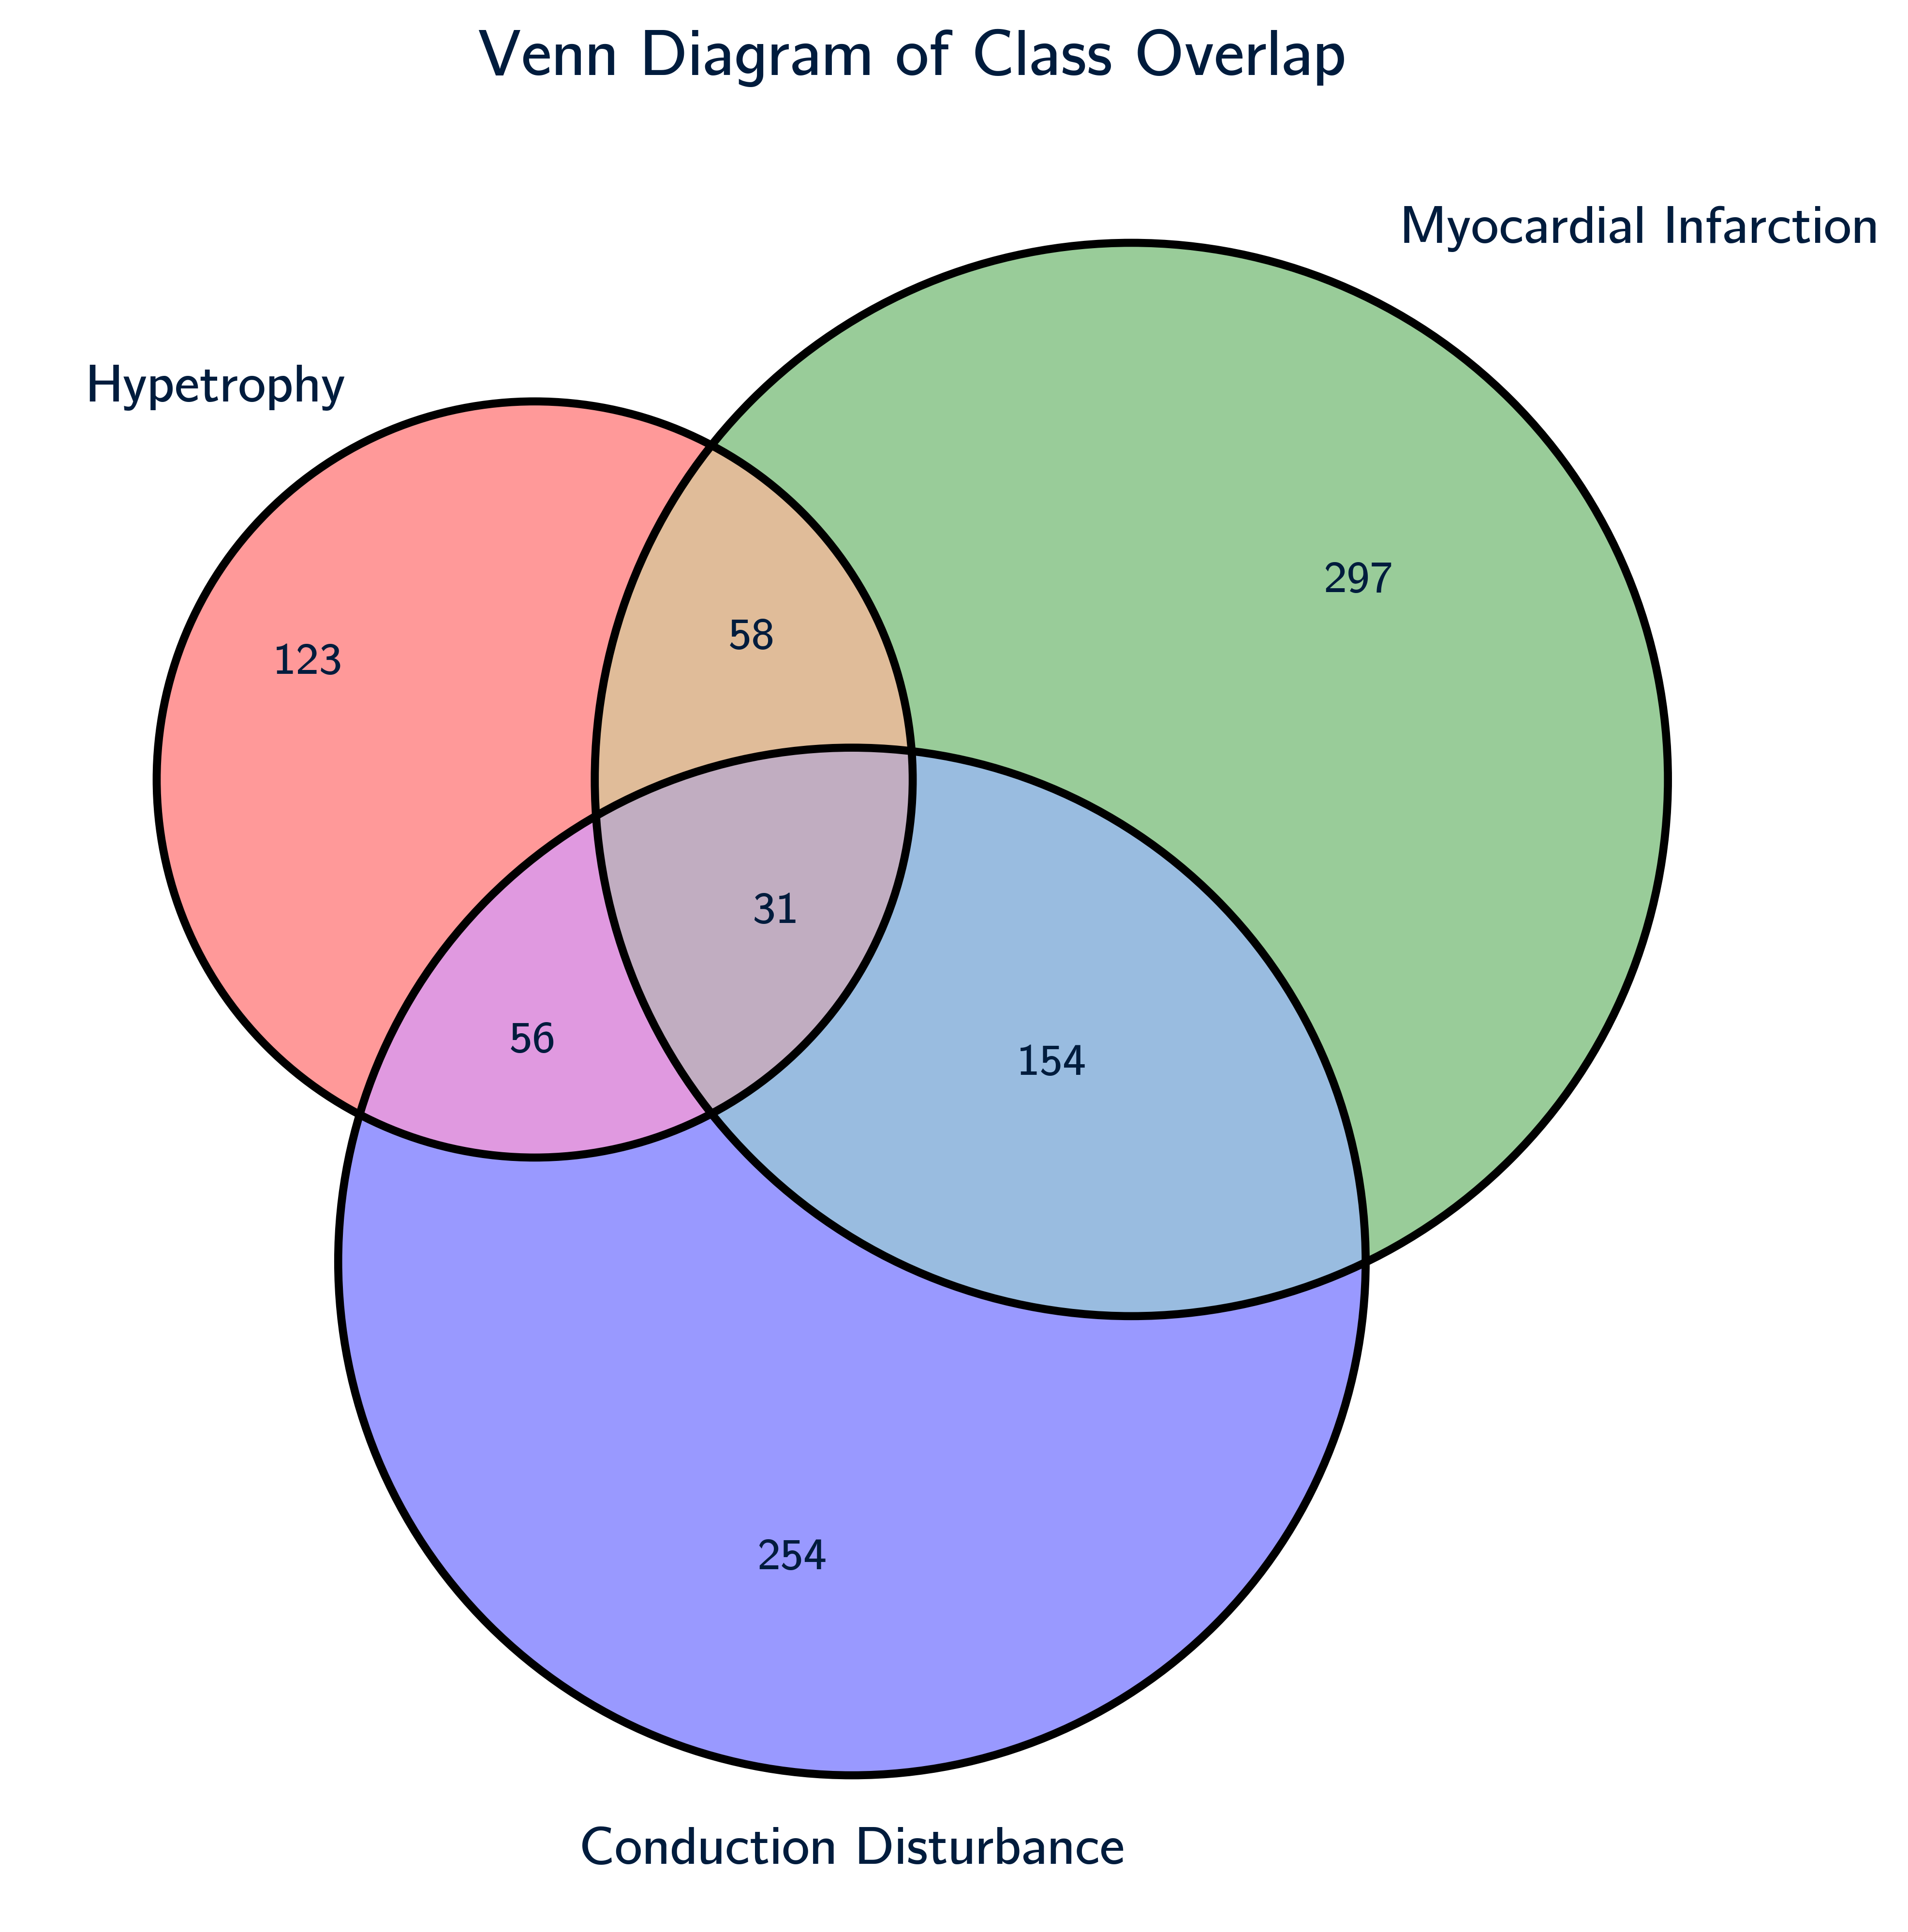

In [ ]:
# Plot the overlap between the classes as a Venn diagram
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles


# Create a Venn diagram for the overlap between the classes
plt.figure(figsize=(12, 8), dpi=600)
venn3((set(hyp_idx), set(mi_idx), set(cd_idx)), ('Hypetrophy', 'Myocardial Infarction', 'Conduction Disturbance'))
venn3_circles((set(hyp_idx), set(mi_idx), set(cd_idx)))
plt.title("Venn Diagram of Class Overlap", fontsize=16, fontweight='bold')


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

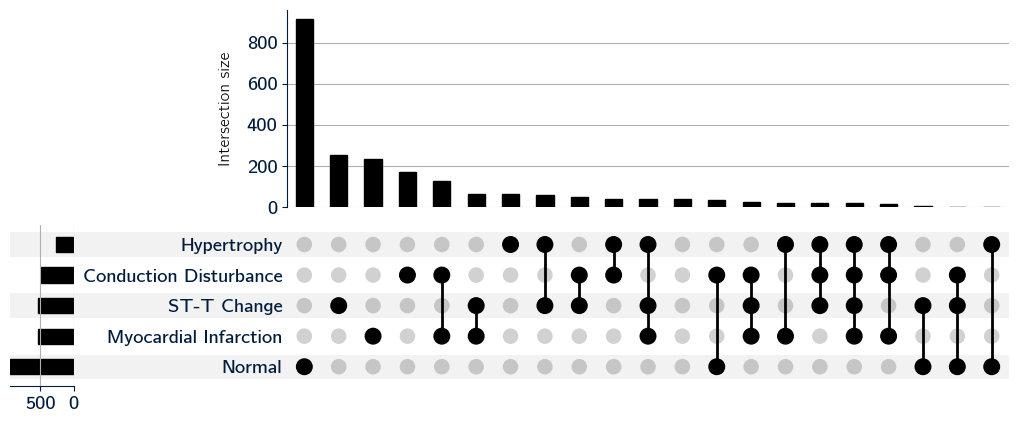

In [ ]:
from upsetplot import UpSet, from_indicators

# Create a DataFrame for the upset plot
overlap_df = pd.DataFrame({
    'Hypertrophy': [1 if i in hyp_idx else 0 for i in range(len(meta_val))],
    'Myocardial Infarction': [1 if i in mi_idx else 0 for i in range(len(meta_val))],
    'Conduction Disturbance': [1 if i in cd_idx else 0 for i in range(len(meta_val))],
    'ST-T Change': [1 if i in sttc_idx else 0 for i in range(len(meta_val))],
    'Normal': [1 if i in norm_idx else 0 for i in range(len(meta_val))],
})

# Convert to boolean values
overlap_df = overlap_df.astype(bool)

# Create the upset plot
indicators = from_indicators(overlap_df)
up = UpSet(indicators, subset_size='sum', sort_by='cardinality')
up.plot()

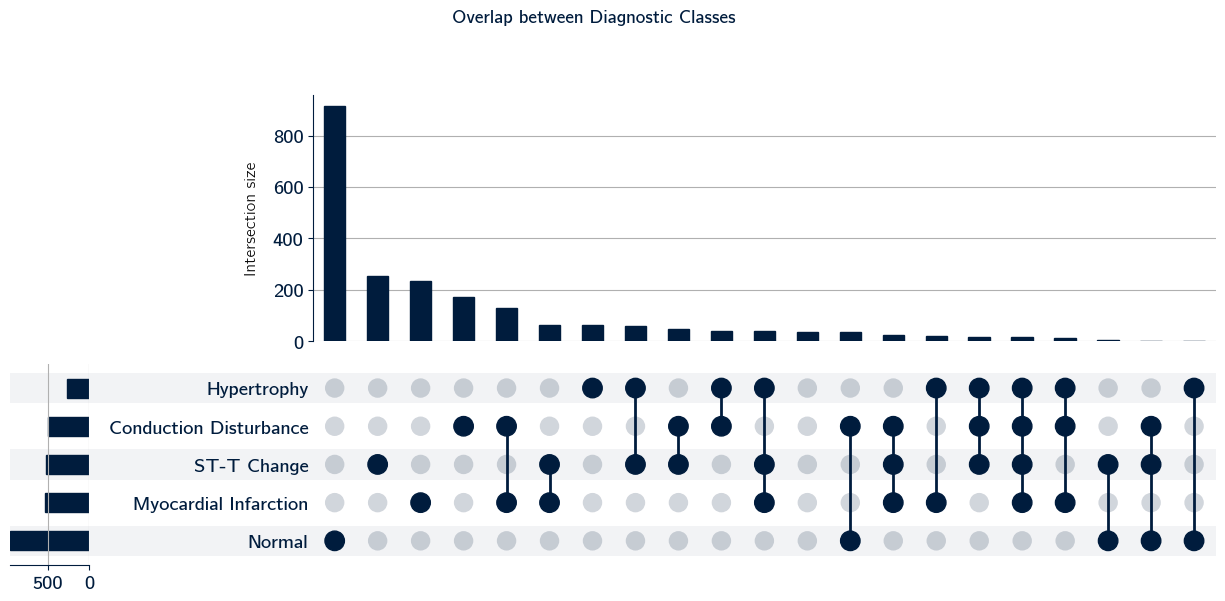

In [ ]:
from upsetplot import UpSet, from_indicators

###############################################################################
# 1.  Maastricht-University palette (primary + accent)
###############################################################################
MU_DARK_BLUE  = "#001C3D"   # primary corporate blue :contentReference[oaicite:0]{index=0}
MU_LIGHT_BLUE = "#00A2DB"   # accent blue          :contentReference[oaicite:1]{index=1}
MU_ORANGE     = "#E84E10"   # accent orange-red     :contentReference[oaicite:2]{index=2}
MU_WHITE      = "#FFFFFF"
GREY          = "#D3D3D3"   # neutral for minor dots

###############################################################################
# 2.  Matplotlib defaults that give an “identity‐consistent” look
###############################################################################
plt.rcParams.update({
    "figure.figsize"       : (10, 6),
    "axes.titlesize"       : 15,
    "axes.labelsize"       : 12,
    "font.size"            : 11,
    "axes.facecolor"       : MU_WHITE,
    "figure.facecolor"     : MU_WHITE,
    "axes.edgecolor"       : MU_DARK_BLUE,
    "xtick.color"          : MU_DARK_BLUE,
    "ytick.color"          : MU_DARK_BLUE,
    "text.color"           : MU_DARK_BLUE,
})

###############################################################################
# 3.  Build the UpSet object
###############################################################################
# `overlap_df` already exists from your code -------------------------------
indicators = from_indicators(overlap_df)

up = UpSet(
    indicators,
    subset_size="sum",
    sort_by="cardinality",
    element_size=40,             # bigger dots
    facecolor=MU_DARK_BLUE,      # colour of the bars (overridden below)
)

up.plot()

plt.suptitle("Overlap between Diagnostic Classes", weight="bold", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
mistake_mask = predictions != targets
mistake_counts = mistake_mask.sum(axis=1)
wrong = []
for i in range(1, 7):
    wrong.append(np.where(mistake_counts >= i)[0])

print(wrong[0])
print(len(wrong[0]))

[   9   23   34   35   36   52   78   83   92  122  166  185  198  215
  224  226  228  239  304  325  380  387  394  419  463  468  470  471
  476  483  486  524  538  567  578  580  581  632  669  673  683  686
  689  717  727  749  754  797  837  848  859  872  881  883  905  936
  948  955  956  961  966  999 1000 1004 1056 1058 1065 1067 1074 1077
 1080 1183 1198 1206 1215 1218 1220 1240 1250 1259 1290 1293 1296 1320
 1379 1395 1407 1433 1459 1468 1486 1495 1510 1511 1512 1546 1550 1595
 1610 1614 1632 1647 1691 1709 1753 1754 1789 1808 1862 1911 2004 2011
 2027 2041 2176 2177]
116


In [ ]:
# Find all samples where diagnostic superclass is empty
empties = meta[meta['diagnostic_superclass'].apply(lambda x: len(x) == 0)]

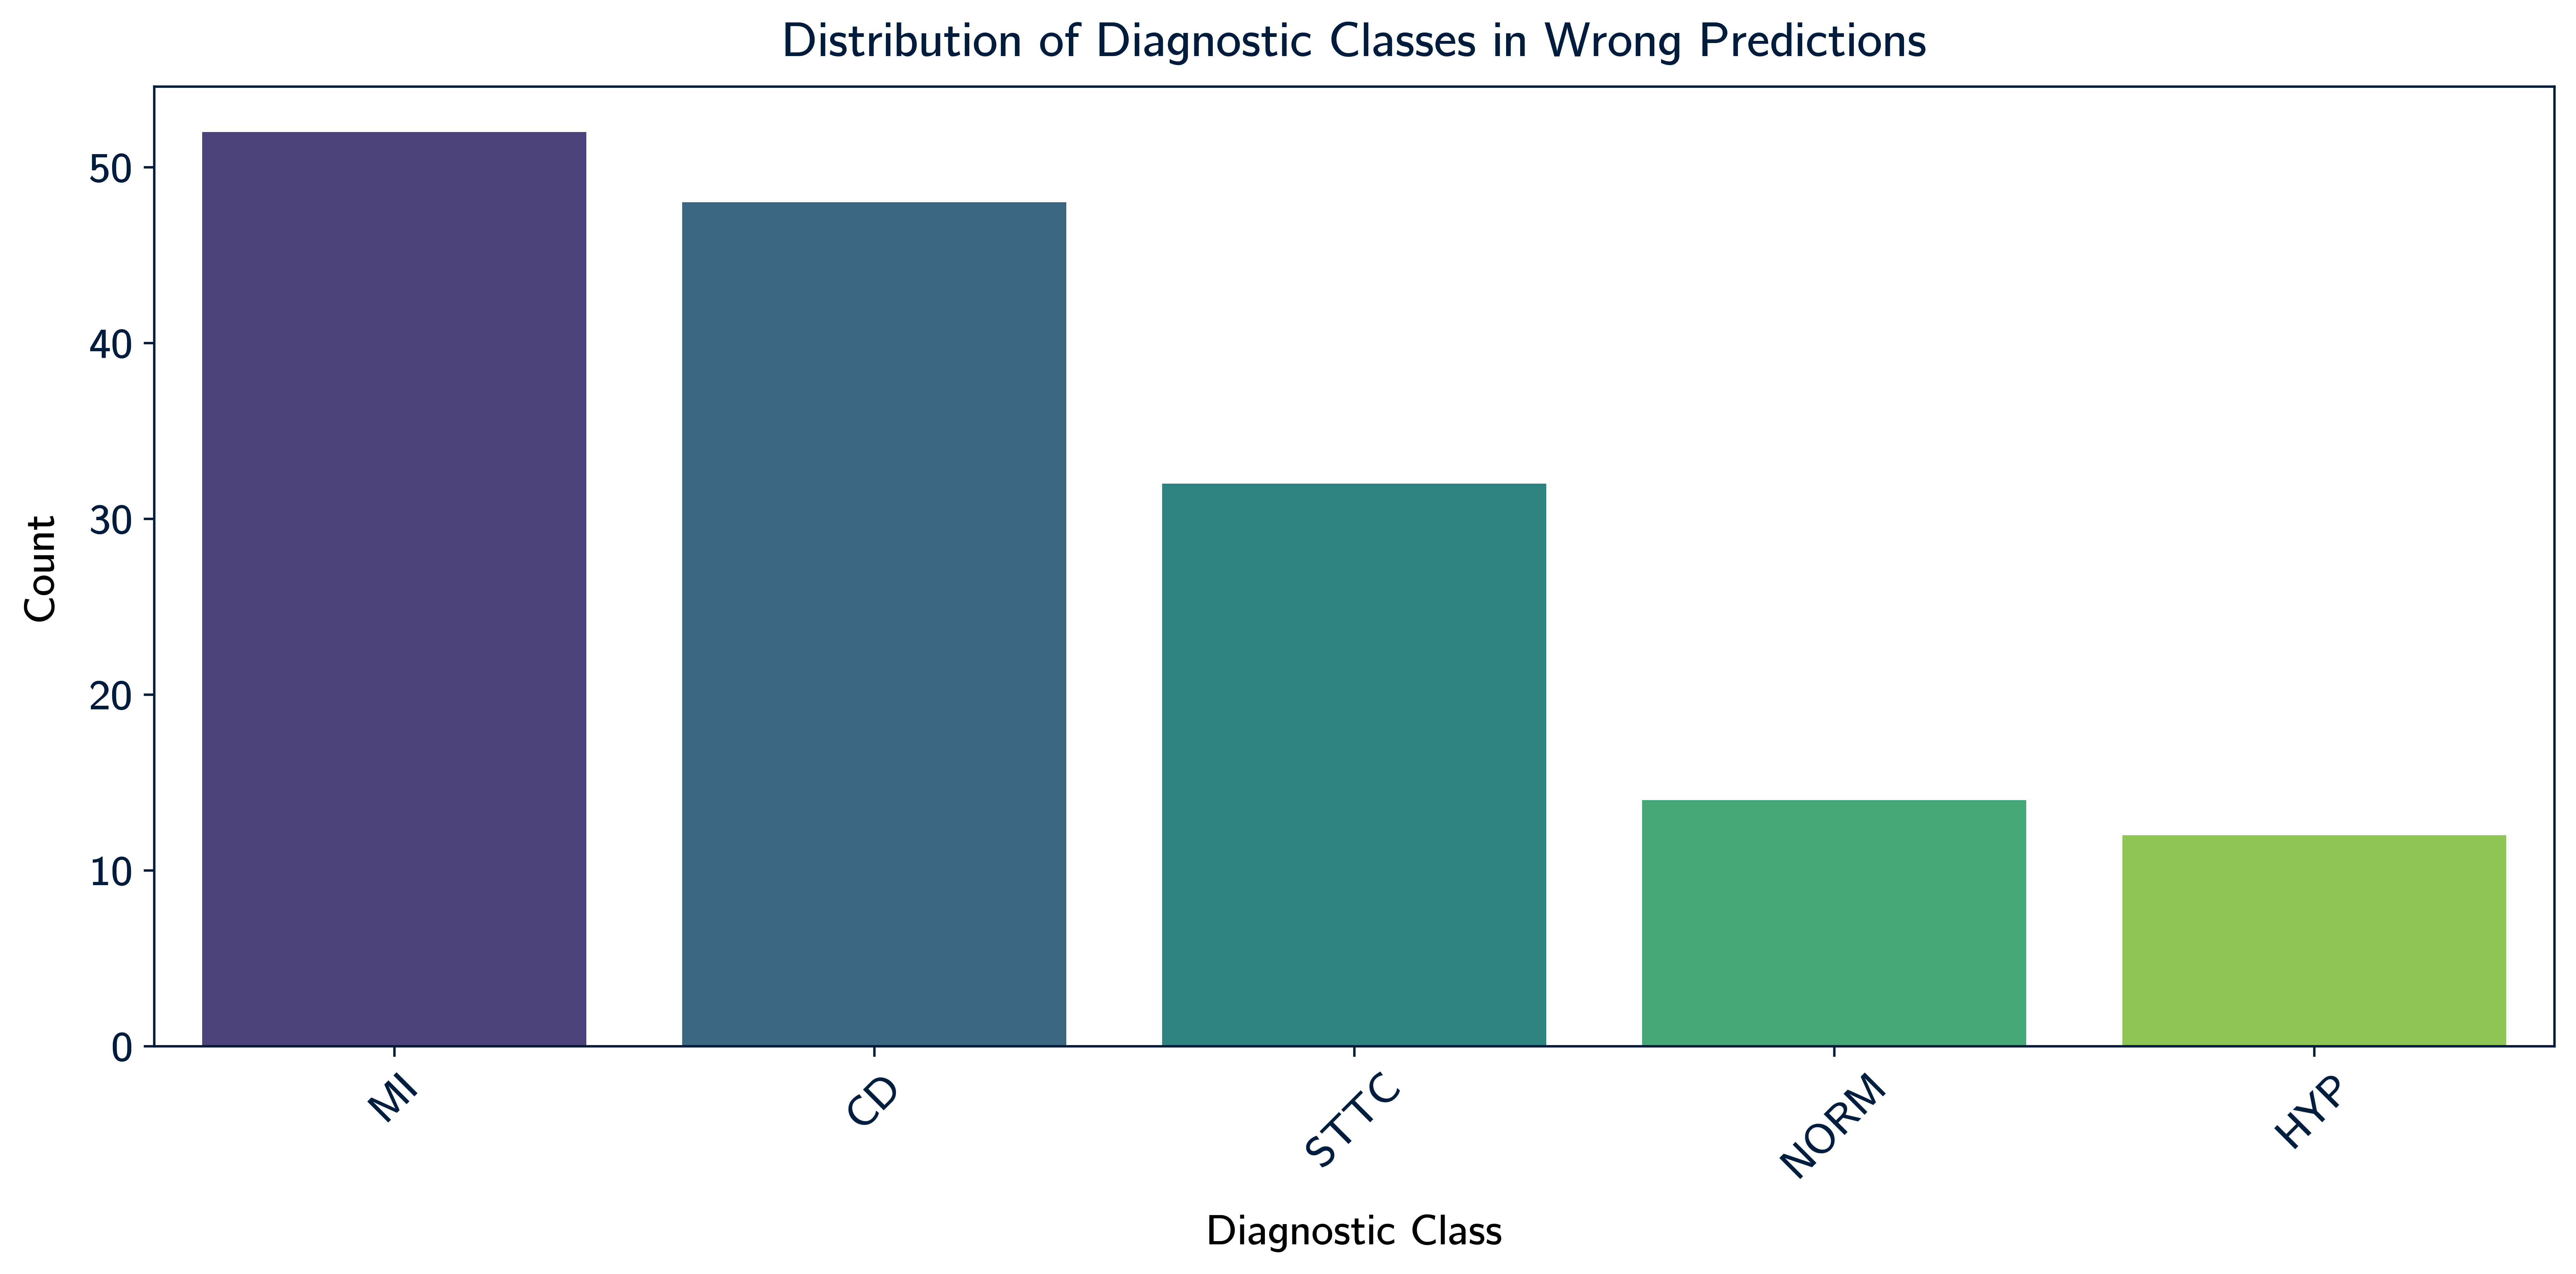

In [ ]:
from collections import Counter
# Find the distribution of diagnostic classes in the wrong predictions

wrong_diagnostic_classes = meta.iloc[wrong[0]]['diagnostic_superclass'].values
# Flatten the list of lists
wrong_diagnostic_classes_flat = [item for sublist in wrong_diagnostic_classes for item in sublist]
# Count the occurrences of each diagnostic class
wrong_diagnostic_classes_count = Counter(wrong_diagnostic_classes_flat)
# Create a DataFrame from the counts
wrong_diagnostic_classes_df = pd.DataFrame(wrong_diagnostic_classes_count.items(), columns=['diagnostic_class', 'count'])
# Sort the DataFrame by count
wrong_diagnostic_classes_df = wrong_diagnostic_classes_df.sort_values(by='count', ascending=False)
# Plot the distribution of diagnostic classes in the wrong predictions
plt.figure(figsize=(12, 6), dpi=600)
sns.barplot(x='diagnostic_class', y='count', data=wrong_diagnostic_classes_df, palette="viridis")
plt.title("Distribution of Diagnostic Classes in Wrong Predictions", fontsize=16, weight="bold")
plt.xlabel("Diagnostic Class", fontsize=14, weight="bold")
plt.ylabel("Count", fontsize=14, weight="bold")
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
wrong_norm = np.where(meta.iloc[wrong[0]]['diagnostic_superclass'].apply(lambda x: 'NORM' in x))[0]
wrong_mi = np.where(meta.iloc[wrong[0]]['diagnostic_superclass'].apply(lambda x: 'MI' in x))[0]
wrong_cd = np.where(meta.iloc[wrong[0]]['diagnostic_superclass'].apply(lambda x: 'CD' in x))[0]
wrong_sttc = np.where(meta.iloc[wrong[0]]['diagnostic_superclass'].apply(lambda x: 'STTC' in x))[0]
wrong_hyp = np.where(meta.iloc[wrong[0]]['diagnostic_superclass'].apply(lambda x: 'HYP' in x))[0]
wrong_others = np.where(meta.iloc[wrong[0]]['diagnostic_superclass'].apply(lambda x: 'NORM' not in x and 'MI' not in x and 'CD' not in x and 'STTC' not in x and 'HYP' not in x))[0]

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

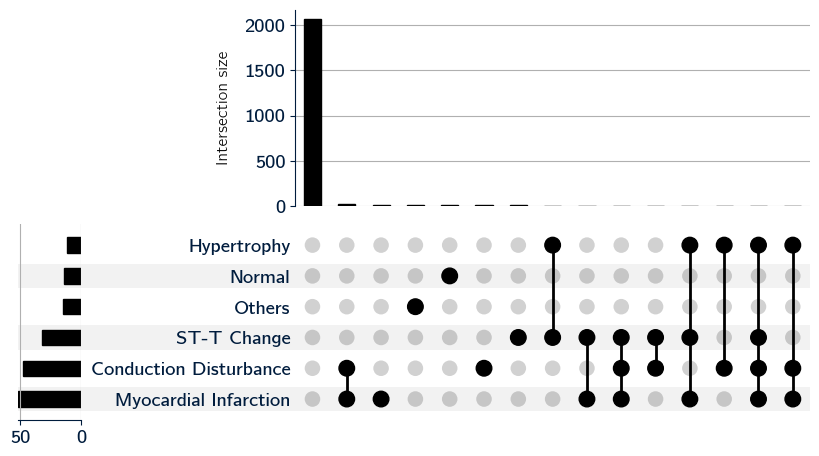

In [ ]:
# Create a DataFrame for the upset plot
overlap_df = pd.DataFrame({
    'Hypertrophy': [1 if i in wrong_hyp else 0 for i in range(len(meta))],
    'Myocardial Infarction': [1 if i in wrong_mi else 0 for i in range(len(meta))],
    'Conduction Disturbance': [1 if i in wrong_cd else 0 for i in range(len(meta))],
    'ST-T Change': [1 if i in wrong_sttc else 0 for i in range(len(meta))],
    'Normal': [1 if i in wrong_norm else 0 for i in range(len(meta))],
    'Others': [1 if i in wrong_others else 0 for i in range(len(meta))],
})

# Convert to boolean values
overlap_df = overlap_df.astype(bool)

# Create the upset plot
indicators = from_indicators(overlap_df)
up = UpSet(indicators, subset_size='sum', sort_by='cardinality')
up.plot()